<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fc/Flag_of_Mexico.svg/320px-Flag_of_Mexico.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition mexicaine du *Huff Post* (2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Mexique"
huff = huff[huff.pays == edition]
huff.shape

(2168, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

The Huffington Post Mexico    2138
Excélsior                     22  
ESPN.com.mx                   2   
Dinero en Imagen.com          1   
El Universal                  1   
El Huffington Post            1   
El Diario de Juárez           1   
Excelsior                     1   
Milenio                       1   
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

The Huffington Post Mexico    2138
El Huffington Post            1   
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(2139, 13)

In [7]:
len(huff) - len(huff[metaHP])

29

Le calcul ci-haut nous indique qu'on a **29 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

Cristina Díaz Editora de Entretenimiento en Huffington Post México                                  279
Roberto Sierra Editor Estilo de vida, Huffington Post México                                        177
Manuel Hernández Borbolla Reportero. Ganador del Premio Alemán de Periodismo Walter Reuter 2014.    174
Carolina Ruiz Editora de Negocios y Tecnología. The Huffington Post México.                         166
Sandra Lucario Editora en Huffington Post México                                                    157
? ?                                                                                                 150
Redacción The Huffington Post México                                                                127
Luis Baylón Editor HuffPost México                                                                  94 
Teresa Villa Editora de Noticias Internacionales                                                    90 
Guillermina Ortiz Editora Senior Front Page & News              

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent un peu moins de **7%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(150, 6.9188191881918826)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(1503, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(Cristina Díaz Editora de Entretenimiento en Huffington Post México                279
 Roberto Sierra Editor Estilo de vida, Huffington Post México                      177
 Carolina Ruiz Editora de Negocios y Tecnología. The Huffington Post México.       166
 Sandra Lucario Editora en Huffington Post México                                  157
 Redacción The Huffington Post México                                              127
 Luis Baylón Editor HuffPost México                                                94 
 Paola Morales Editora de Política en Huffington Post                              56 
 ? The Huffington Post                                                             38 
 Karen Cota Editora de Política, Huffington Post México                            31 
 Alejandro Angeles Editor, Huffington Post Mexico                                  30 
 ? Entertainment Writer, The Huffington Post                                       23 
 ? El Huffington Post                      

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **1&nbsp;503 articles** signés par **125e signataires différents**.<br>
Cela représente un peu plus des deux tiers de l'ensemble des articles publiés par cette édition du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(1503, 69.326568265682653)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(636, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(Manuel Hernández Borbolla Reportero. Ganador del Premio Alemán de Periodismo Walter Reuter 2014.      174
 ? ?                                                                                                   150
 Teresa Villa Editora de Noticias Internacionales                                                      90 
 Guillermina Ortiz Editora Senior Front Page & News                                                    62 
 Vanessa Mota                                                                                          27 
 Ariel Heiblum Editor de Video                                                                         26 
 Notimex                                                                                               25 
 Excélsior                                                                                             14 
 ? Entertainment Editor                                                                                6  
 ? Periodista                        

On constate que plusieurs de ces noms désignent des postes au *HuffPost*, sinon des pigistes. On peut donc considérer que 413 de ces 636 articles signés par des auteurs «&nbsp;Non HuffPost&nbsp;» sont en fait des créateurs de contenu original pour cette édition du *HuffPost*.

Il faut donc les ajouter à notre variable `HP_oui`.

In [15]:
HP_oui = huff[metaHP][signeHP].pays.count() + 413
HP_oui, (HP_oui/len(huff))*100

(1916, 88.376383763837637)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, additionner les articles qu'on a identifiés plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, et retrancher enfin tous les articles qu'on vient d'ajouter à notre variable `HP_oui`.

In [16]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 413
HP_non, (HP_non/len(huff))*100

(102, 4.7047970479704802)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

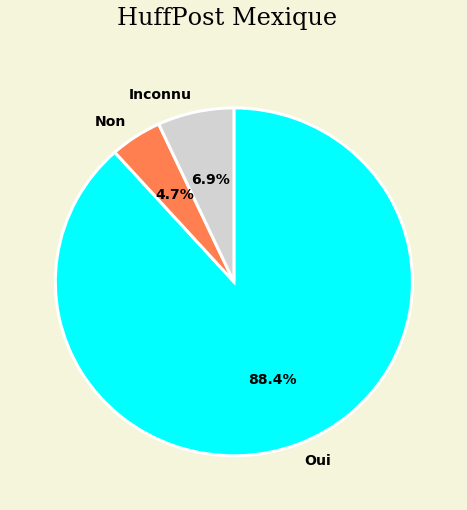

In [17]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Mexique", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [18]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

ENTRETENIMIENTO           659
POLÍTICA                  435
INTERNACIONAL             397
NEGOCIOS                  271
ESTILO DE VIDA            255
Elecciones EU             240
Donald Trump              195
WELLNESS                  156
hpmx                      148
donald trump              126
México                    110
Hillary Clinton           79 
                          .. 
capital                   1  
indocumentados            1  
asteoride                 1  
rehabilitación            1  
HboGo                     1  
LadyBajate                1  
Primer Ministro           1  
Ellen DeGeneres           1  
4k                        1  
Federico Reyes Heroles    1  
Controversia              1  
hombre transgenero        1  
Length: 4869, dtype: int64